In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Part A

In [2]:
''' This function calculates the Euclidean distance between two vectors. '''
def Euclidean(vector1, vector2):
    return np.sqrt(np.abs(vector1**2 - vector2**2).sum())

''' This function calculates the Manhattan distance between two vectors. '''
def Manhattan(vector1, vector2):
    return np.abs(vector1 - vector2).sum()

In [3]:
class DBSCAN:
    def __init__(self):
        pass
    
    def RangeQuery(self, X, point, eps, distance_metric):
        neighbors = []
        for row in X:
            if distance_metric(point, row) <= eps:
                neighbors.append(row)
        return np.array(neighbors)
    
    def fit(self, X, eps, min_samples, distance_metric="euclidean"):
        
        if distance_metric=="manhattan":
            self.distance_metric = Manhattan
        else:
            self.distance_metric = Euclidean
            
        C = 0
        processed = np.empty(X.shape[0])
        processed[:] = np.nan
        for row, i in zip(X, range(X.shape[0])):
            if ~np.isnan(processed[i]):
                continue
            neighbors = self.RangeQuery(X, row, eps, self.distance_metric)
            if len(neighbors) < min_samples:
                # Label noise by -1.
                processed[i] = -1
                continue
            C = C + 1
            processed[i] = C
            # Remove self from neighbors list.
            for neighbor, i in zip(neighbors, range(neighbors.shape[0])):
                if (neighbor==row).all():
                    self_index = i
            seed = np.delete(neighbors, self_index, axis=0)
            for neighbor in seed:
                for i in range(X.shape[0]):
                    if (neighbor==X[i]).all():
                        index = i
                        break
                if processed[index] == -1:
                    processed[index] = C
                if ~np.isnan(processed[index]):
                    continue
                processed[index] = C
                neighbors = self.RangeQuery(X, neighbor, eps, self.distance_metric)
                if len(neighbors) >= min_samples:
                    np.append(seed, neighbors)
        return processed

# Part B
We wish to load in the MovieLens dataset and do some basic analysis, pulling out specific columns of interest, dropping null values, getting rid of movies with low votes, and standardizing the remaining data.

In [4]:
fields = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']
df = pd.read_csv('movies_metadata.csv', sep=',', usecols=fields, low_memory=False)
df

,budget,popularity,revenue,runtime,vote_average,vote_count
0,30000000,21.946943,373554033.0,81.0,7.7,5415.0
1,65000000,17.015539,262797249.0,104.0,6.9,2413.0
2,0,11.7129,0.0,101.0,6.5,92.0
3,16000000,3.859495,81452156.0,127.0,6.1,34.0
4,0,8.387519,76578911.0,106.0,5.7,173.0
...,...,...,...,...,...,...
45461,0,0.072051,0.0,90.0,4.0,1.0
45462,0,0.178241,0.0,360.0,9.0,3.0
45463,0,0.903007,0.0,90.0,3.8,6.0
45464,0,0.003503,0.0,87.0,0.0,0.0


In [5]:
df = df.dropna()
df.isnull().sum()

budget          0
popularity      0
revenue         0
runtime         0
vote_average    0
vote_count      0
dtype: int64

In [6]:
df = df[df['vote_count'] > 30]

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = scaler.fit_transform(df)

Now we take a look at finding the optimal k using inertia and silhouette score analyses.

In [8]:
from sklearn.cluster import KMeans
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(data) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

Text(0.5, 1.0, 'Inertias for Different Values of k')

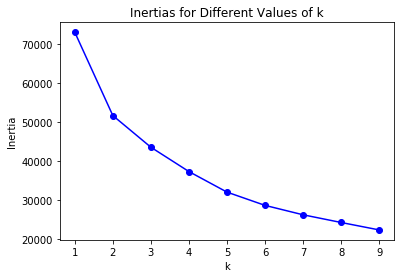

In [9]:
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Inertias for Different Values of k')

Text(0.5, 1.0, 'Silhouette Scores for Different Values of k')

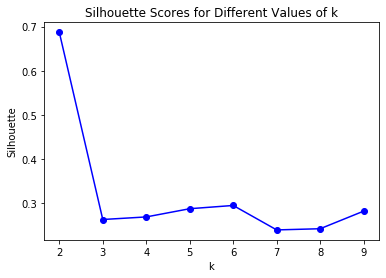

In [10]:
from sklearn.metrics import silhouette_score
silhouette_scores = [silhouette_score(data, model.labels_) for model in kmeans_per_k[1:]]
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel('k')
plt.ylabel('Silhouette')
plt.title('Silhouette Scores for Different Values of k')

The optimal k appears to be 2 in both cases, as this corresponds to the highest positive value in our silhouette score and the elbow in our inertia analysis.

Next, we will perform our KMeans clustering on the data. scikit-learn's KMeans only allows Euclidean distance. At first, I considered Manhattan distance to be more useful because of the discrepencies in values for our data (i.e., revenue is in millions/billions, other fields are much smaller). However, data standardization resolves some of these problems, making Euclidean distance a viable metric.

In [11]:
kmeans = KMeans(n_clusters = 2)
kmeans.fit(data)

y_pred = kmeans.fit_predict(data)
y_pred

array([1, 1, 0, ..., 0, 0, 0])

In [12]:
data[(y_pred == 0)], data[(y_pred == 1)]

(array([[-0.47494004,  0.39574524, -0.34487794, -0.09626718,  0.20802257,
         -0.33235181],
        [ 0.04060013, -0.41154718,  0.33867361,  0.76535888, -0.2271213 ,
         -0.39740084],
        [-0.47494004,  0.053912  ,  0.29777703,  0.06943014, -0.66226517,
         -0.24150749],
        ...,
        [-0.47494004, -0.22573744, -0.34487794, -0.69277752, -0.11833533,
         -0.39403623],
        [-0.47494004,  1.33209447, -0.34487794, -3.31079516,  2.16616998,
         -0.27178893],
        [-0.47494004, -0.35676823, -0.34487794, -0.09626718, -1.20619501,
         -0.27291047]]),
 array([[ 4.91697788e-01,  1.44775584e+00,  2.79001069e+00,
         -7.59056452e-01,  1.51345417e+00,  5.63757820e+00],
        [ 1.61944193e+00,  9.40831129e-01,  1.86053288e+00,
          3.15121523e-03,  6.43166436e-01,  2.27073058e+00],
        [ 1.45833562e+00,  1.03431186e+00,  1.22810347e+00,
          2.19035582e+00,  1.51345417e+00,  1.67968171e+00],
        ...,
        [ 5.88784639e+00,  

Now, we employ our DBSCAN model.

In [13]:
import time
start = time.time()
my_dbscan = DBSCAN()
eps = 2
clusters = my_dbscan.fit(X=data, eps=eps, min_samples=5, distance_metric='euclidean')
end = time.time()

run_time = end - start
run_time, clusters

(1479.1945033073425, array([-1.,  1.,  2., ...,  2., 46.,  2.]))

In [14]:
# Counting anomalies and number of clusters.
(clusters < 0).sum(), max(clusters)

(508, 100.0)

In [15]:
# Looking at two different clusters.
data[clusters == 1], data[clusters == 64]

(array([[ 1.61944193,  0.94083113,  1.86053288,  0.00315122,  0.64316644,
          2.27073058],
        [ 1.87721202, -0.72726951,  1.57752968,  0.83163781, -0.11833533,
          2.39970709],
        [ 1.61944193,  0.52337001,  1.84811827,  0.30140639,  0.86073837,
          1.5215453 ],
        [ 1.94165454,  0.70059985,  1.73734473,  0.06943014,  0.64316644,
          1.80080747],
        [ 1.94165454,  0.47232726,  1.82254   ,  0.201988  ,  0.0992366 ,
          2.4613915 ],
        [ 1.13612301,  1.19929653,  1.83786373,  0.26826693,  0.31680853,
          2.36381797],
        [ 1.13612301,  1.21166464,  1.52495405,  0.06943014,  0.53438047,
          2.14624021],
        [ 1.78054823,  0.86895456,  1.46385649, -0.39452235, -0.11833533,
          2.29989048],
        [ 1.61944193,  0.55451933,  1.6328476 ,  0.53338264,  0.64316644,
          2.46924225],
        [ 1.45833562,  1.07036851,  1.65637738, -0.26196449,  0.7519524 ,
          1.92641938],
        [ 1.94165454,  1.07400

In [16]:
from sklearn.cluster import DBSCAN as skDBSCAN
start = time.time()
sk_dbscan = skDBSCAN(eps=1, min_samples=5, metric='euclidean')
print(sk_dbscan.fit_predict(data), (sk_dbscan.fit_predict(data) < 0).sum())
end = time.time()
print(end - start)

[-1  0  0 ...  0  0  0] 444
3.8795018196105957


In [17]:
(sk_dbscan.fit_predict(data) != y_pred).sum()

674

# Part C

In [18]:
df = pd.read_csv('NHL-2003-2004.csv', sep=',')
df

,Player,Season,Team,S/C,Pos,GP,G,A,P,+/-,...,EVP,PPG,PPP,SHG,SHP,GWG,S,S%,TOI/GP,FOW%
0,Martin St. Louis,20032004,TBL,L,R,82,38,56,94,35,...,53,8,30,8,11,7,212,17.9,20:35,33.3
1,Ilya Kovalchuk,20032004,ATL,R,L,81,41,46,87,-10,...,52,16,33,1,2,6,341,12,23:06,32.1
2,Joe Sakic,20032004,COL,L,C,81,33,54,87,11,...,49,13,37,1,1,3,253,13,20:16,52.6
3,Markus Naslund,20032004,VAN,L,L,78,35,49,84,24,...,58,5,26,0,0,6,296,11.8,19:23,35.7
4,Marian Hossa,20032004,OTT,L,R,81,36,46,82,4,...,42,14,39,1,1,5,233,15.4,18:37,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,Melvin Angelstad,20032004,WSH,L,L,2,0,0,0,0,...,0,0,0,0,0,0,1,0,13:00,--
912,Patrick Leahy,20032004,BOS,R,R,6,0,0,0,1,...,0,0,0,0,0,0,2,0,5:27,--
913,Denis Hamel,20032004,OTT,L,L,5,0,0,0,-3,...,0,0,0,0,0,0,6,0,6:16,100
914,Blake Sloan,20032004,DAL,R,R,28,0,0,0,-1,...,0,0,0,0,0,0,23,0,7:11,0


In [19]:
print('Rows: ' + str(df.shape[0]))
print('Columns: ' + str(df.shape[1]))

Rows: 916
Columns: 23


In [20]:
df = df.replace('--', 0.0)
df['S%'] = df['S%'].astype(float)

In [21]:
X1 = df[['GP', 'G', 'S%']].to_numpy()
X2 = df[['P', '+/-', 'PIM']].to_numpy()
X1, X2

(array([[82. , 38. , 17.9],
        [81. , 41. , 12. ],
        [81. , 33. , 13. ],
        ...,
        [ 5. ,  0. ,  0. ],
        [28. ,  0. ,  0. ],
        [ 4. ,  0. ,  0. ]]),
 array([[ 94,  35,  24],
        [ 87, -10,  63],
        [ 87,  11,  42],
        ...,
        [  0,  -3,   0],
        [  0,  -1,   7],
        [  0,  -1,  19]], dtype=int64))

Now we run scikit-learn's LocalOutlierFactor on our data, varying k's to find an optimal one.

In [22]:
from sklearn.neighbors import LocalOutlierFactor

# Our range of k's.
k_list = np.arange(1, 15)

# Initialize X1 and X2 LOF matrices.
X1_neg_lof = np.ones((X1.shape[0], len(k_list))) * 99999
X2_neg_lof = np.ones((X2.shape[0], len(k_list))) * 99999

for i in range(k_list.size):
    X1_lof = LocalOutlierFactor(n_neighbors=k_list[i], algorithm='auto', contamination='auto', n_jobs=-1)
    X2_lof = LocalOutlierFactor(n_neighbors=k_list[i], algorithm='auto', contamination='auto', n_jobs=-1)
    X1_lof.fit(X1)
    X2_lof.fit(X2)
    
    for j in range(len(X1_lof.negative_outlier_factor_)):
        X1_neg_lof[j, i] = X1_lof.negative_outlier_factor_[j]
    for j in range(len(X2_lof.negative_outlier_factor_)):
        X2_neg_lof[j, i] = X2_lof.negative_outlier_factor_[j]
        
# Here we report the number of anomalies for all k's in our range. We choose 2 as the cut-off because anomalies should
# be much greater than 1, and since we have some pretty big anomalies, counting values just slightly larger than 1 seems
# bad, and results in over half of our data being anomalous for most k-values.
X1_anom_count = (np.abs(X1_neg_lof) > 1.2).sum(axis=0)
X2_anom_count = (np.abs(X1_neg_lof) > 1.2).sum(axis=0)

print('X1 Anomalies: ', X1_anom_count)
print('X2 Anomalies: ', X2_anom_count)

X1 Anomalies:  [232 206 156 129 108 101  99 101  96  93 102  90  96 100]
X2 Anomalies:  [232 206 156 129 108 101  99 101  96  93 102  90  96 100]


From the above analysis, we see that our number of anomalies seems is high at lower k's, but stabilizes at around k=6, at which point it sticks close to around 10% of the data. We choose k=7 as our optimal value below.

I was not sure if "first 3-5" outliers meant the 3-5 lowest-valued outliers, or the first ones that appear. The isolation forest seems only capable of doing the latter, but I have done both for LOF.

In [23]:
X1_optimal = X1_neg_lof[:, 8]
X2_optimal = X2_neg_lof[:, 8]

# Search optimal k for top 3 outliers.
X1_tops = X1_optimal.argsort()
X2_tops = X2_optimal.argsort()

print('\t\t  Index   Negative LOF')
for i in range(0, 3):
    print('X1 Outlier Rank ' + str(i+1) + ':', X1_tops[i], X1_optimal[X1_tops[i]])
for i in range(0, 3):    
    print('X2 Outlier Rank ' + str(i+1) + ':', X2_tops[i], X2_optimal[X2_tops[i]])
    
# Values with LOF > 1 are anomalous.
X1_firsts = np.where(np.abs(X1_optimal) > 1)
X2_firsts = np.where(np.abs(X2_optimal) > 1)
print('\n')
print('\t\t    Index')
for i in range(0, 3):
    print('X1 Outlier Number ' + str(i+1) + ':', X1_firsts[0][i])
    
for i in range(0, 3):    
    print('X2 Outlier Number ' + str(i+1) + ':', X2_firsts[0][i])

		  Index   Negative LOF
X1 Outlier Rank 1: 889 -5555555556.555555
X1 Outlier Rank 2: 589 -5555555556.555555
X1 Outlier Rank 3: 758 -5555555556.555555
X2 Outlier Rank 1: 851 -8888888889.88889
X2 Outlier Rank 2: 912 -8888888889.88889
X2 Outlier Rank 3: 781 -8641975309.609562


		    Index
X1 Outlier Number 1: 0
X1 Outlier Number 2: 1
X1 Outlier Number 3: 3
X2 Outlier Number 1: 0
X2 Outlier Number 2: 1
X2 Outlier Number 3: 2


As a sanity check, we can look into the corresponding indices, and see that for the features we chose they have the same values, which explains the identical LOF scores.

In [24]:
print('Rank 1 Data:', X1[889])
print('Rank 1 Data:', X1[589])
print('Rank 1 Data:', X1[758])
print('Rank 1 Data:', X2[851])
print('Rank 1 Data:', X2[912])
print('Rank 1 Data:', X2[781])

Rank 1 Data: [8. 0. 0.]
Rank 1 Data: [8. 0. 0.]
Rank 1 Data: [8. 0. 0.]
Rank 1 Data: [0 1 0]
Rank 1 Data: [0 1 0]
Rank 1 Data: [ 1 -1  2]


We will compare the findings of the LOF ranking to one derived from scikit-learn's isolation forest.

In [25]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.1, max_features=1.0, bootstrap=False, verbose=1, n_jobs=-1, random_state=42)
iso_X1 = isolation_forest.fit_predict(X1)
iso_X2 = isolation_forest.fit_predict(X2)
iso_X1, iso_X2

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    0.0s remaining:    0.6s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   2 out of  16 | elapsed:    0.0s remaining:    0.5s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.0s finished


(array([-1, -1, -1, -1, -1, -1, -1,  1, -1,  1, -1, -1, -1, -1, -1, -1,  1,
         1, -1,  1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1,  1,  1, -1,  1,
         1,  1, -1,  1,  1,  1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1, -1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
         1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,
         1, -1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
         1, 

Above we can see that the first three values of our data are anomalous for both feature sets, according to the isolation forest. This largely agrees with our findings from the LOF, though the third data point was not found to be anomalous in X1 with LOF. We also see that we get a comparable amount of anomalies.

In [26]:
iso_X1[iso_X1 == -1].sum(), iso_X2[iso_X2 == -1].sum()

(-92, -92)

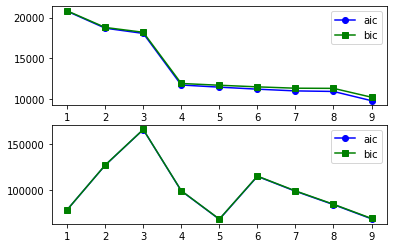

In [27]:
from sklearn.mixture import GaussianMixture
X1_gmms = [GaussianMixture(n_components=k).fit(X1) for k in range(1, 10)]
X2_gmms = [GaussianMixture(n_components=k).fit(X2) for k in range(1, 10)]

X1_aic = []
X1_bic = []
X2_aic = []
X2_bic = []

for gmm in X1_gmms:
    X1_aic.append(gmm.aic(X1))
    X1_bic.append(gmm.bic(X1))
    
for gmm in X1_gmms:
    X2_aic.append(gmm.aic(X2))
    X2_bic.append(gmm.bic(X2))
    
fig, ax = plt.subplots(2)
ax[0].plot(range(1, 10), X1_aic, "bo-", label='aic')
ax[0].plot(range(1, 10), X1_bic, "gs-", label='bic')
ax[1].plot(range(1, 10), X2_aic, "bo-", label='aic')
ax[1].plot(range(1, 10), X2_bic, "gs-", label='bic')
ax[0].legend()
ax[1].legend() 

The minimum for both features, and for both measures, occurs at k = 6. This is our optimal parameter for number of components.

In [28]:
optimal_gmm = GaussianMixture(n_components=6)
X1_pred = optimal_gmm.fit_predict(X1)
X2_pred = optimal_gmm.fit_predict(X2)

Our previous models labeled approximately 10% of the data as anomalous. We'll use that to find anomalies with our GM model, setting 10% as our density threshold.

In [29]:
X1_densities = gmm.score_samples(X1)
X2_densities = gmm.score_samples(X2)

X1_anomalies = np.where(X1_densities < np.percentile(X1_densities, 10))
X2_anomalies = np.where(X2_densities < np.percentile(X2_densities, 10))
# List first three.
for i in range(0, 3):
    print('X1 Outlier Number ' + str(i+1) + ':', X1_anomalies[0][i])
    
for i in range(0, 3):
    print('X2 Outlier Number ' + str(i+1) + ':', X2_anomalies[0][i])

X1 Outlier Number 1: 1
X1 Outlier Number 2: 3
X1 Outlier Number 3: 5
X2 Outlier Number 1: 1
X2 Outlier Number 2: 15
X2 Outlier Number 3: 17


This performs much more poorly, as expected, since it assumes a Gaussian distribution of data. Isolation forest and LOF should both work better.